In [1]:
ENV["PYTHON"] = "" 
using Pkg
Pkg.build("PyCall")  # Rebuild PyCall to use the internal Python
using PyPlot, DelimitedFiles
ENV["PYTHON"] = "" 
using Pkg
Pkg.build("PyCall")  # Rebuild PyCall to use the internal Python
using PyPlot, DelimitedFiles


    Building Conda ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/b19db3927f0db4151cb86d073689f2428e524576/build.log`
    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/9816a3826b0ebf49ab4926e2b18842ad8b5c8f04/build.log`


LoadError: InitError: KeyError: key "register_cmap" not found
during initialization of module PyPlot

## Possible hitchiking

In [ ]:
muts = zeros(21,199); 
for a in 1:21 
    for i in 1:199 
        seq = copy(wt_seq); 
        seq[i] = a; 
        muts[a,i] = Genie.delta_energy(h, J, seq, wt_seq) 
    end 
end

muts_nowt = []
for a in 1:21
    for i in 1:199
        if a != wt_seq[i]
            push!(muts_nowt, muts[a,i])
        end
    end
end



f1,f2 = compute_weighted_frequencies(mcmc.step_msa[end], 22, 0.); mcmcf= reshape(f1, 21, 199);
f1,f2 = compute_weighted_frequencies(popgen.step_msa[end], 22, 0.); popgenf= reshape(f1, 21, 199);

@load "../pse_popgen_meanf.jld2"

exp_msa = read_fasta_alignment("../data_directed_evolution/pse_round20_noflankgaps_nodupl.fa", 0.9)
f1,f2 = compute_weighted_frequencies(exp_msa, 22, 0.); expf= reshape(f1, 21, 199); expf2 = reshape(f2, 21, 199, 21, 199);


function hitchhiking_stat(Zexp;
    q=21, 
    freq_min = 0.01)
    L = size(Zexp,1)
    f1, f2 = DCAUtils.compute_weighted_frequencies(Int8.(Zexp), q + 1, 0.)
    Cnat  = reshape(f2 - f1 * f1',q,L,q,L)
    den = reshape((f1 .* (1 .- f1)) * (f1 .* (1 .- f1))',q,L,q,L)
    r2 = (Cnat .^2) ./ (den)
    mask = (f1 .> freq_min) .& (f1 .< 1 - freq_min)
    mask2 = mask * mask'
    mask3 = reshape(mask2,q,L,q,L)
    return Cnat, r2, r2[mask3], mask3
end

freq_min = 0.01
cij_exp, r2_exp, r2_exp_masked, mask = hitchhiking_stat(exp_msa, freq_min = freq_min)
hitch_ind = findall(x -> x == 1, mask .& (r2_exp .> 0.3) )
positions = [[I[1], I[2], I[3], I[4]] for I in hitch_ind]
filtered_positions = [pos for pos in positions if pos[2] != pos[4]]



popgen_nowt = []; mcmc_nowt = []; exp_nowt = [];
for a in 1:21
    for i in 1:199
        if a != wt_seq[i]
            push!(popgen_nowt, f_popgen[a,i])
            push!(mcmc_nowt, mcmcf[a,i])
            push!(exp_nowt, expf[a,i])
        end
    end
end


cor(popgen_nowt, exp_nowt)
cor(mcmc_nowt, exp_nowt)

cor(muts_nowt, exp_nowt)
cor(muts_nowt, mcmc_nowt)
cor(muts_nowt, popgen_nowt)




## Fig2

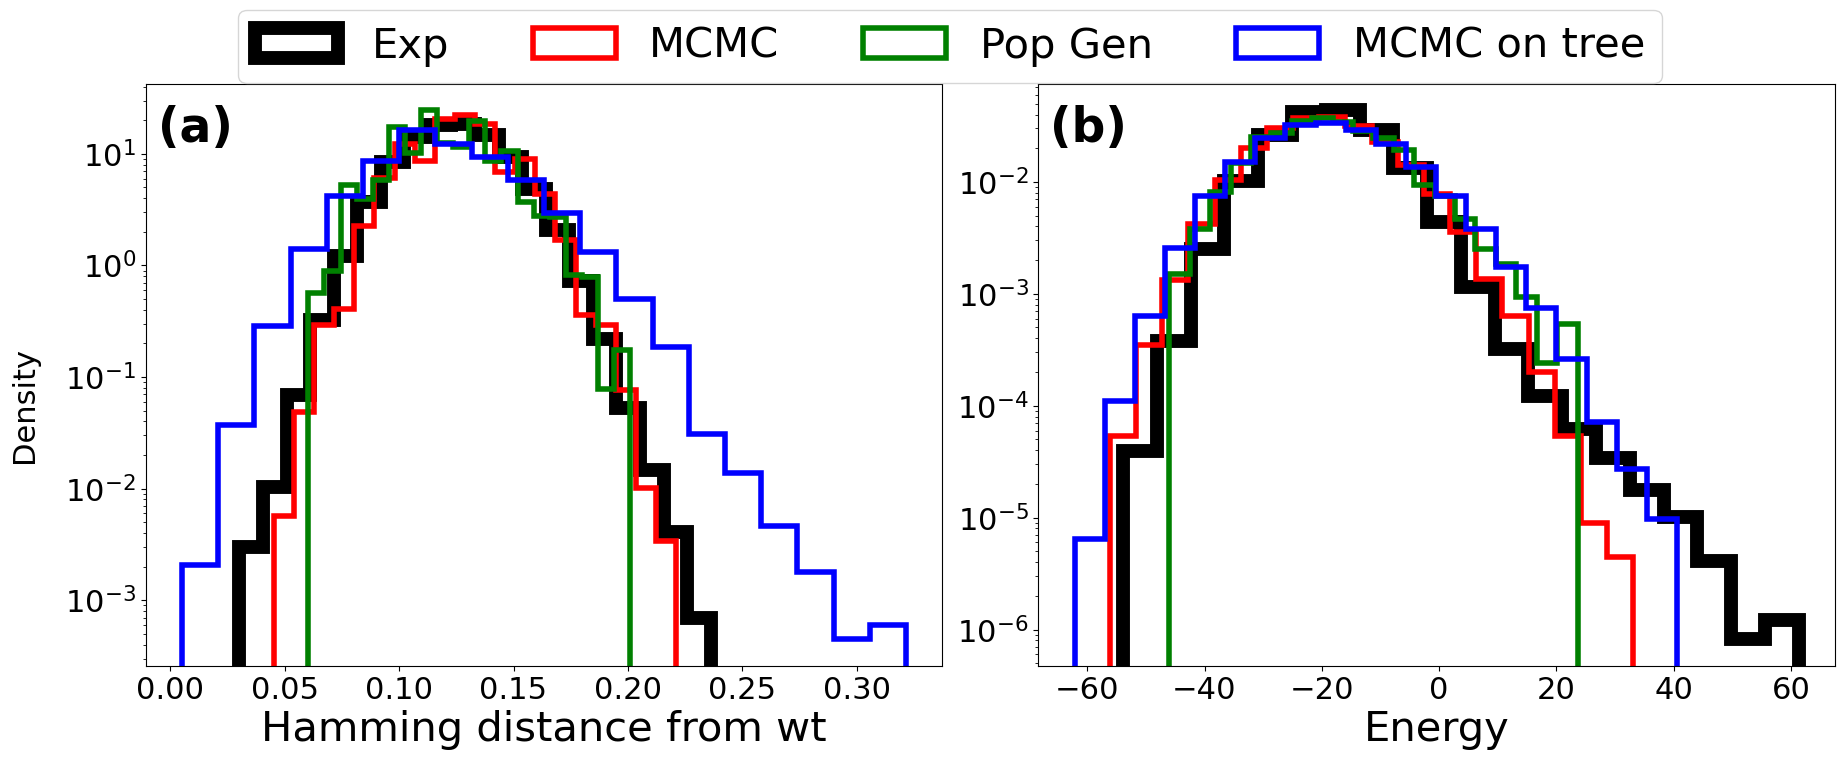

In [15]:
L = 199

# Parameters
n_bins = 20
n_points = 1000
colors = ["black", "red", "green", "blue"]
labels = ["Exp", "MCMC", "Pop Gen", "MCMC on tree"]

target_ham = readdlm("../../data_directed_evolution/targets/ham_PSE_round20.txt")
target_en = readdlm("../../data_directed_evolution/targets/en_PSE_round20.txt")

mcmc_ham = readdlm("../../data_directed_evolution/best_fit/ham_PSE_mcmc_samples100000_T1.3_steps120_pairs10000.txt")
mcmc_en = readdlm("../../data_directed_evolution/best_fit/en_PSE_mcmc_samples100000_T1.3_steps120_pairs10000.txt")

mcmctree_ham = readdlm("../../data_directed_evolution/best_fit/ham_PSE_mcmctree_T1.4_steps110_pairs10000.txt")
mcmctree_en = readdlm("../../data_directed_evolution/best_fit/en_PSE_mcmctree_T1.4_steps110_pairs10000.txt")

popgen_ham = readdlm("../../data_directed_evolution/best_fit/ham_PSE_popgen_samples100000_T12.0_mu0.03_mubind-50.0_pairs10000.txt")
popgen_en = readdlm("../../data_directed_evolution/best_fit/en_PSE_popgen_samples100000_T12.0_mu0.03_mubind-50.0_pairs10000.txt")

# Create figure and 1×2 subplots
fig, axs = subplots(1, 2, figsize=(20, 8), sharey=false)

# --- Panel (a): Hamming distance ---
axs[1].hist(target_ham ./L, histtype="step", color=colors[1], linewidth=10, bins=20, density=true)
axs[1].hist(mcmc_ham ./L, histtype="step", color=colors[2], linewidth=4, bins=20, density=true)
axs[1].hist(popgen_ham ./L, histtype="step", color=colors[3], linewidth=4, bins=20, density=true)
axs[1].hist(mcmctree_ham ./L, histtype="step", color=colors[4], linewidth=4, bins=20, density=true)
axs[1].set_yscale("log")
axs[1].set_xlabel("Hamming distance from wt", fontsize=30)


# --- Panel (b): Energy ---
axs[2].hist(target_en, histtype="step", color=colors[1], linewidth=10, bins=20, density=true)
axs[2].hist(mcmc_en, histtype="step", color=colors[2], linewidth=4, bins=20, density=true)
axs[2].hist(popgen_en, histtype="step", color=colors[3], linewidth=4, bins=20, density=true)
axs[2].hist(mcmctree_en, histtype="step", color=colors[4], linewidth=4, bins=20, density=true)
axs[2].set_yscale("log")
axs[2].set_xlabel("Energy", fontsize=30)


# Add label (a)
axs[1].text(0.015, 0.9, "(a)", transform=axs[1].transAxes,
            fontsize=34, fontweight="bold")

# Add label (b)
axs[2].text(0.015, 0.9, "(b)", transform=axs[2].transAxes,
            fontsize=34, fontweight="bold")

# Adjust tick sizes
for ax in axs
    ax.tick_params(axis="both", labelsize=22)
end

# Shared legend
fig.legend(labels, loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.02), fontsize=30)

# Common Y label
fig.text(0.03, 0.5, "Density", va="center", rotation="vertical", fontsize=22)

# Adjust layout
fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.92])

show()

savefig("../../Fig2.pdf")


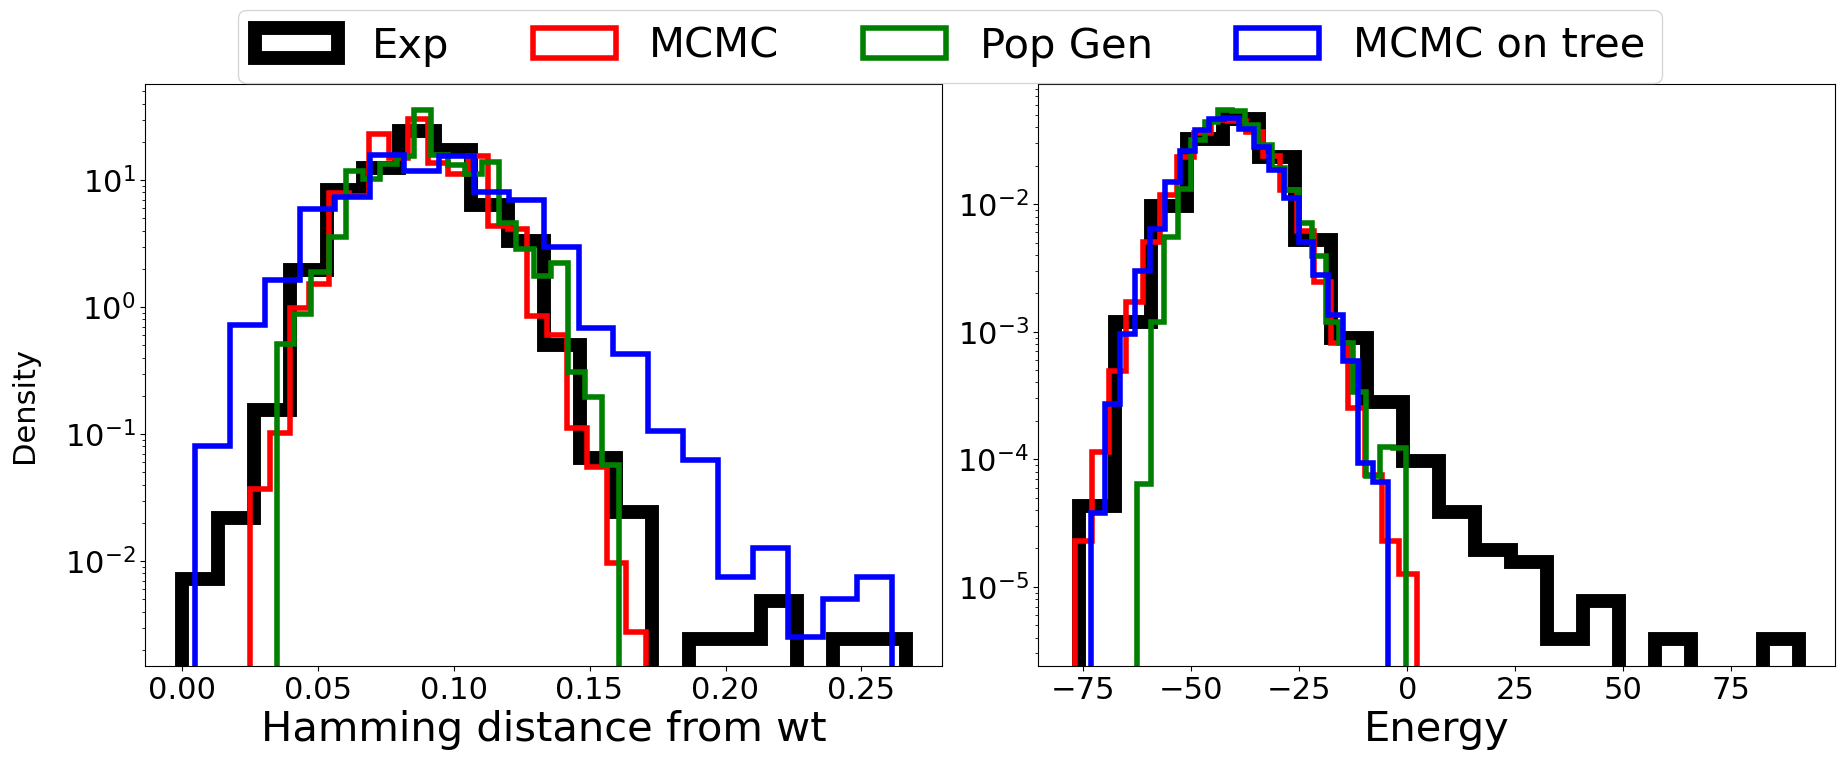

In [6]:
L = 199

# Parameters
n_bins = 20
n_points = 1000
colors = ["black", "red", "green", "blue"]
labels = ["Exp", "MCMC", "Pop Gen", "MCMC on tree"]


target_ham = readdlm("../../data_directed_evolution/targets/ham_TEM_round12.txt")
target_en = readdlm("../../data_directed_evolution/targets/en_TEM_round12.txt")

mcmc_ham = readdlm("../../data_directed_evolution/best_fit/ham_TEM_mcmc_samples100000_T1.1_steps95_pairs10000.txt")
mcmc_en = readdlm("../../data_directed_evolution/best_fit/en_TEM_mcmc_samples100000_T1.1_steps95_pairs10000.txt")

mcmctree_ham = readdlm("../../data_directed_evolution/best_fit/ham_TEM_mcmctree_T1.1_steps100_pairs10000.txt")
mcmctree_en = readdlm("../../data_directed_evolution/best_fit/en_TEM_mcmctree_T1.1_steps100_pairs10000.txt")

popgen_ham = readdlm("../../data_directed_evolution/best_fit/ham_TEM_popgen_samples100000_T6.0_mu0.035_mubind-50.0_pairs10000.txt")
popgen_en = readdlm("../../data_directed_evolution/best_fit/en_TEM_popgen_samples100000_T6.0_mu0.035_mubind-50.0_pairs10000.txt")


# Create figure and 2x2 subplots
fig, axs = subplots(1, 2, figsize=(20, 8), sharey=false)


axs[1].hist(target_ham ./L, histtype = "step", color = colors[1], linewidth = 10, bins = 20, density = true)
axs[1].hist(mcmc_ham ./L, histtype = "step", color = colors[2], linewidth = 4, bins = 20, density = true)
axs[1].hist(popgen_ham ./L, histtype = "step", color = colors[3], linewidth = 4, bins = 20, density = true)
axs[1].hist(mcmctree_ham ./L, histtype = "step", color = colors[4], linewidth = 4, bins = 20, density = true)
axs[1].set_yscale("log")
axs[1].set_xlabel("Hamming distance from wt", fontsize = 30)
#axs[1].set_xlim(-0.1,0.35)


axs[2].hist(target_en, histtype = "step", color = colors[1], linewidth = 10, bins = 20, density = true)
axs[2].hist(mcmc_en, histtype = "step", color = colors[2], linewidth = 4, bins = 20, density = true)
axs[2].hist(popgen_en, histtype = "step", color = colors[3], linewidth = 4, bins = 20, density = true)
axs[2].hist(mcmctree_en, histtype = "step", color = colors[4], linewidth = 4, bins = 20, density = true)
axs[2].set_yscale("log")
axs[2].set_xlabel("Energy", fontsize = 30)
#axs[2].set_xlim(-25,120)

# Set tick label size for both subplots
for ax in axs
    ax.tick_params(axis="both", labelsize=22)  # Adjust 22 as needed
end


# Create a single shared legend outside the plots
fig.legend(labels, loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.02), fontsize = 30)

# Common axis labels
fig.text(0.03, 0.5, "Density", va="center", rotation="vertical", fontsize=22)

# Adjust layout to make room for labels and legend
fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.92])
show()

savefig("../../tem_comparison_popgen.png", dpi = 700) 

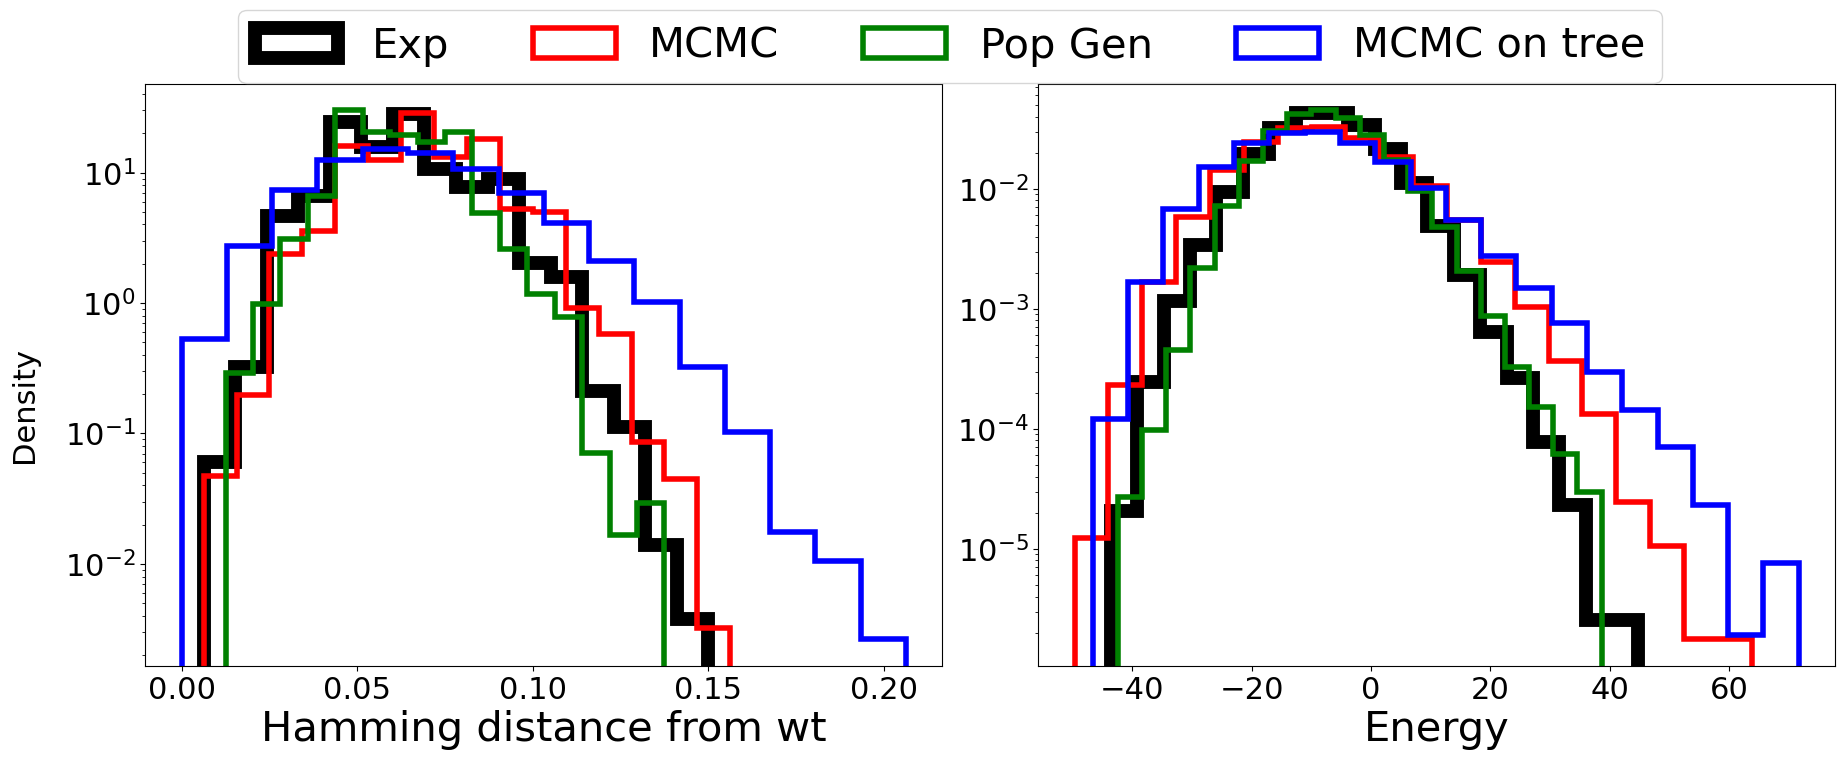

In [7]:
L = 160

# Parameters
n_bins = 20
n_points = 1000
colors = ["black", "red", "green", "blue"]
labels = ["Exp", "MCMC", "Pop Gen", "MCMC on tree"]


target_ham = readdlm("../../data_directed_evolution/targets/ham_DHFR_round15.txt")
target_en = readdlm("../../data_directed_evolution/targets/en_DHFR_round15.txt")

mcmc_ham = readdlm("../../data_directed_evolution/best_fit/ham_DHFR_mcmc_samples100000_T2.2_steps60_pairs10000.txt")
mcmc_en = readdlm("../../data_directed_evolution/best_fit/en_DHFR_mcmc_samples100000_T2.2_steps60_pairs10000.txt")

mcmctree_ham = readdlm("../../data_directed_evolution/best_fit/ham_DHFR_mcmctree_T2.2_steps60_pairs10000.txt")
mcmctree_en = readdlm("../../data_directed_evolution/best_fit/en_DHFR_mcmctree_T2.2_steps60_pairs10000.txt")

popgen_ham = readdlm("../../data_directed_evolution/best_fit/ham_DHFR_popgen_samples100000_T8.0_mu0.02_mubind-10.0_pairs10000.txt")
popgen_en = readdlm("../../data_directed_evolution/best_fit/en_DHFR_popgen_samples100000_T8.0_mu0.02_mubind-10.0_pairs10000.txt")


# Create figure and 2x2 subplots
fig, axs = subplots(1, 2, figsize=(20, 8), sharey=false)


axs[1].hist(target_ham ./L, histtype = "step", color = colors[1], linewidth = 10, bins = 16, density = true)
axs[1].hist(mcmc_ham ./L, histtype = "step", color = colors[2], linewidth = 4, bins = 16, density = true)
axs[1].hist(popgen_ham ./L, histtype = "step", color = colors[3], linewidth = 4, bins = 16, density = true)
axs[1].hist(mcmctree_ham ./L, histtype = "step", color = colors[4], linewidth = 4, bins = 16, density = true)
axs[1].set_yscale("log")
axs[1].set_xlabel("Hamming distance from wt", fontsize = 30)
#axs[1].set_xlim(-0.1,0.35)


axs[2].hist(target_en, histtype = "step", color = colors[1], linewidth = 10, bins = 20, density = true)
axs[2].hist(mcmc_en, histtype = "step", color = colors[2], linewidth = 4, bins = 20, density = true)
axs[2].hist(popgen_en, histtype = "step", color = colors[3], linewidth = 4, bins = 20, density = true)
axs[2].hist(mcmctree_en, histtype = "step", color = colors[4], linewidth = 4, bins = 20, density = true)
axs[2].set_yscale("log")
axs[2].set_xlabel("Energy", fontsize = 30)
#axs[2].set_xlim(-25,120)

# Set tick label size for both subplots
for ax in axs
    ax.tick_params(axis="both", labelsize=22)  # Adjust 22 as needed
end


# Create a single shared legend outside the plots
fig.legend(labels, loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.02), fontsize = 30)

# Common axis labels
fig.text(0.03, 0.5, "Density", va="center", rotation="vertical", fontsize=22)

# Adjust layout to make room for labels and legend
fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.92])
show()

savefig("../../dhfr_comparison_popgen.png", dpi = 700) 

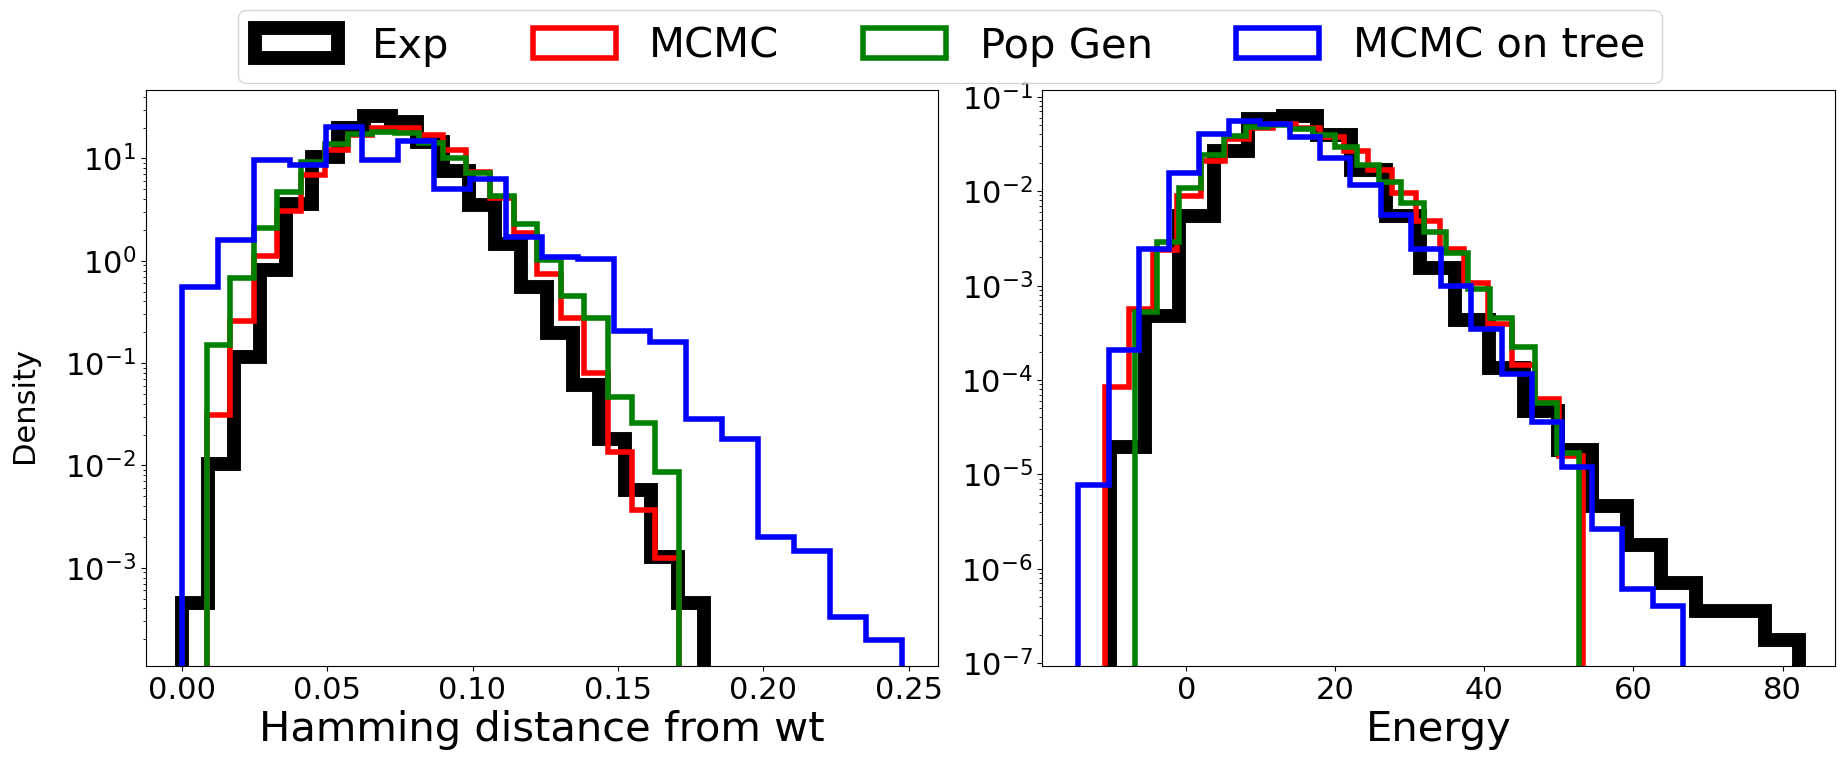

In [8]:
L = 117

# Parameters
n_bins = 20
n_points = 1000
colors = ["black", "red", "green", "blue"]
labels = ["Exp", "MCMC", "Pop Gen", "MCMC on tree"]


target_ham = readdlm("../../data_directed_evolution/targets/ham_AAC_round8.txt")
target_en = readdlm("../../data_directed_evolution/targets/en_AAC_round8.txt")

mcmc_ham = readdlm("../../data_directed_evolution/best_fit/ham_AAC_mcmc_samples100000_T2.1_steps30_pairs10000.txt")
mcmc_en = readdlm("../../data_directed_evolution/best_fit/en_AAC_mcmc_samples100000_T2.1_steps30_pairs10000.txt")

mcmctree_ham = readdlm("../../data_directed_evolution/best_fit/ham_AAC_mcmctree_T1.8_steps30_pairs10000.txt")
mcmctree_en = readdlm("../../data_directed_evolution/best_fit/en_AAC_mcmctree_T1.8_steps30_pairs10000.txt")

popgen_ham = readdlm("../../data_directed_evolution/best_fit/ham_AAC_popgen_samples100000_T10.0_mu0.035_mubind0.0_pairs10000.txt")
popgen_en = readdlm("../../data_directed_evolution/best_fit/en_AAC_popgen_samples100000_T10.0_mu0.035_mubind0.0_pairs10000.txt")


# Create figure and 2x2 subplots
fig, axs = subplots(1, 2, figsize=(20, 8), sharey=false)


axs[1].hist(target_ham ./L, histtype = "step", color = colors[1], linewidth = 10, bins = 20, density = true)
axs[1].hist(mcmc_ham ./L, histtype = "step", color = colors[2], linewidth = 4, bins = 20, density = true)
axs[1].hist(popgen_ham ./L, histtype = "step", color = colors[3], linewidth = 4, bins = 20, density = true)
axs[1].hist(mcmctree_ham ./L, histtype = "step", color = colors[4], linewidth = 4, bins = 20, density = true)
axs[1].set_yscale("log")
axs[1].set_xlabel("Hamming distance from wt", fontsize = 30)
#axs[1].set_xlim(-0.1,0.35)


axs[2].hist(target_en, histtype = "step", color = colors[1], linewidth = 10, bins = 20, density = true)
axs[2].hist(mcmc_en, histtype = "step", color = colors[2], linewidth = 4, bins = 20, density = true)
axs[2].hist(popgen_en, histtype = "step", color = colors[3], linewidth = 4, bins = 20, density = true)
axs[2].hist(mcmctree_en, histtype = "step", color = colors[4], linewidth = 4, bins = 20, density = true)
axs[2].set_yscale("log")
axs[2].set_xlabel("Energy", fontsize = 30)
#axs[2].set_xlim(-25,120)

# Set tick label size for both subplots
for ax in axs
    ax.tick_params(axis="both", labelsize=22)  # Adjust 22 as needed
end


# Create a single shared legend outside the plots
fig.legend(labels, loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.02), fontsize = 30)

# Common axis labels
fig.text(0.03, 0.5, "Density", va="center", rotation="vertical", fontsize=22)

# Adjust layout to make room for labels and legend
fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.92])
show()

savefig("../../aac_comparison_popgen.png", dpi = 700) 

## Fig3 

In [10]:
using DelimitedFiles
using PyPlot # Use the PyPlot backend for Matplotlib styling consistency

# --- Data Loading (Row 1: Pairwise Hamming Distance) ---

# Hamming Distance Data (as provided in the prompt)
# NOTE: Ensure these paths are correct relative to where you run the script.
pse_target_pair_ham = readdlm("../data_directed_evolution/targets/pair_ham_PSE_round20.txt")
tem_target_pair_ham = readdlm("../data_directed_evolution/targets/pair_ham_TEM_round12.txt")
aac_target_pair_ham = readdlm("../data_directed_evolution/targets/pair_ham_AAC_round8.txt")
dhfr_target_pair_ham = readdlm("../data_directed_evolution/targets/pair_ham_DHFR_round15.txt")

pse_mcmc_pair_ham = readdlm("../data_directed_evolution/best_fit/pair_ham_PSE_mcmc_samples100000_T1.3_steps120_pairs10000.txt")
pse_popgen_pair_ham = readdlm("../data_directed_evolution/best_fit/pair_ham_PSE_popgen_samples100000_T12.0_mu0.03_mubind-50.0_pairs10000.txt")
pse_mcmctree_pair_ham = readdlm("../data_directed_evolution/best_fit/pair_ham_PSE_mcmctree_T1.4_steps110_pairs10000.txt")

tem_mcmc_pair_ham = readdlm("../data_directed_evolution/best_fit/pair_ham_TEM_mcmc_samples100000_T1.1_steps95_pairs10000.txt")
tem_popgen_pair_ham = readdlm("../data_directed_evolution/best_fit/pair_ham_TEM_popgen_samples100000_T6.0_mu0.035_mubind-50.0_pairs10000.txt")
tem_mcmctree_pair_ham = readdlm("../data_directed_evolution/best_fit/pair_ham_TEM_mcmctree_T1.1_steps100_pairs10000.txt")

aac_mcmc_pair_ham = readdlm("../data_directed_evolution/best_fit/pair_ham_AAC_mcmc_samples100000_T2.1_steps30_pairs10000.txt")
aac_popgen_pair_ham = readdlm("../data_directed_evolution/best_fit/pair_ham_AAC_popgen_samples100000_T10.0_mu0.035_mubind0.0_pairs10000.txt")
aac_mcmctree_pair_ham = readdlm("../data_directed_evolution/best_fit/pair_ham_AAC_mcmctree_T1.8_steps30_pairs10000.txt")

dhfr_mcmc_pair_ham = readdlm("../data_directed_evolution/best_fit/pair_ham_DHFR_mcmc_samples100000_T2.2_steps60_pairs10000.txt")
dhfr_popgen_pair_ham = readdlm("../data_directed_evolution/best_fit/pair_ham_DHFR_popgen_samples100000_T8.0_mu0.02_mubind-10.0_pairs10000.txt")
dhfr_mcmctree_pair_ham = readdlm("../data_directed_evolution/best_fit/pair_ham_DHFR_mcmctree_T2.2_steps60_pairs10000.txt")

pse_neutral_pair_ham = readdlm("../data_directed_evolution/best_fit/pair_ham_PSE_neutral_samples100000_T0.0_mu0.012_mubind0.0_pairs10000.txt")
tem_neutral_pair_ham = readdlm("../data_directed_evolution/best_fit/pair_ham_TEM_neutral_samples100000_T0.0_mu0.014_mubind0.0_pairs10000.txt")
aac_neutral_pair_ham = readdlm("../data_directed_evolution/best_fit/pair_ham_AAC_neutral_samples100000_T0.0_mu0.018_mubind0.0_pairs10000.txt")
dhfr_neutral_pair_ham = readdlm("../data_directed_evolution/best_fit/pair_ham_DHFR_neutral_samples100000_T0.0_mu0.007_mubind0.0_pairs10000.txt")

# --- Data Loading (Row 2: Terminal Branch Length CDF) ---

CDF_DIR = "../data_directed_evolution/best_fit/cdfs/"
wt_names = ["PSE1", "TEM1", "AAC6", "mDHFR"]
labels = ["Exp", "MCMC", "Pop Gen", "MCMC on tree", "Neutral"]
colors = ["black", "red", "green", "blue", "grey"] 

cdf_data = Dict()
for wt_name in wt_names
    cdf_data[wt_name] = Dict()
    for label in labels
        base_name = "$(wt_name)_$(replace(label, " " => "_"))_cdf"
        x_path = joinpath(CDF_DIR, "$(base_name)_lengths.txt")
        y_path = joinpath(CDF_DIR, "$(base_name)_cdf.txt")
        
        try
            # Read data and flatten to a vector
            X = vec(readdlm(x_path))
            Y = vec(readdlm(y_path))
            cdf_data[wt_name][label] = (X, Y)
        catch e
            println("Could not load CDF data for $wt_name - $label: $e")
        end
    end
end

# --- Plotting Parameters ---
n_bins = 20
L_PSE = 199 
L_AAC = 117 
L_DHFR = 160 
linewidths_ham = [10, 4, 4, 4, 4] # Exp, MCMC, Pop Gen, MCMC on tree
linewidths_cdf = [10.0, 4.0, 4.0, 4.0, 4.0] # All 5 models

all_pair_ham_data = [
    (pse_target_pair_ham, pse_mcmc_pair_ham, pse_popgen_pair_ham, pse_mcmctree_pair_ham, pse_neutral_pair_ham, L_PSE),
    (tem_target_pair_ham, tem_mcmc_pair_ham, tem_popgen_pair_ham, tem_mcmctree_pair_ham, tem_neutral_pair_ham, L_PSE),
    (aac_target_pair_ham, aac_mcmc_pair_ham, aac_popgen_pair_ham, aac_mcmctree_pair_ham, aac_neutral_pair_ham, L_AAC),
    (dhfr_target_pair_ham, dhfr_mcmc_pair_ham, dhfr_popgen_pair_ham, dhfr_mcmctree_pair_ham, dhfr_neutral_pair_ham, L_DHFR)
]


# --- PyPlot Implementation (2 Rows, 4 Columns) ---
fig, axs = subplots(2, 4, figsize=(24, 12), sharey="row", sharex=false)

# Set tick label size globally
PyPlot.rc("xtick", labelsize=18)
PyPlot.rc("ytick", labelsize=18)

# --- Row 1: Pairwise Hamming Distance Histograms ---
for i in 1:4
    ax = axs[1, i]
    wt_name = wt_names[i]
    target, mcmc, popgen, mcmctree, neutral, L = all_pair_ham_data[i]

    for j in 1:5
        data = [target, mcmc, popgen, mcmctree, neutral][j]
  
        ax.hist(vec(data) ./ L, 
                bins=n_bins, 
                density=true, 
                histtype="step", 
                color=colors[j], 
                linewidth=linewidths_ham[j], 
                label=labels[j])
    end
    
    # Styling
    ax.set_yscale("log")
    ax.set_title(wt_name, fontsize=22, pad=15)

    # Show xticks on first row
    ax.tick_params(labelbottom=true)

        # Y-label only for first column
    if i == 1
        ax.set_ylabel("Density", fontsize=20)
    end
end

# --- Row 2: Terminal Branch Length CDF Plots ---
for i in 1:4
    ax = axs[2, i]
    wt_name = wt_names[i]
    wt_data = cdf_data[wt_name]
    
    # Plot the 5 CDF lines
    for j in 1:5
        label = labels[j]
        
        if haskey(wt_data, label)
            lengths, cdf = wt_data[label]
            ax.plot(lengths, cdf, 
                    color=colors[j], 
                    linewidth=linewidths_cdf[j], 
                    drawstyle="steps-post", 
                    label=label)
        end
    end
    
    # Styling
    ax.set_ylim(0.0, 1.1)
    ax.tick_params(labelbottom=true)

    # Y-label only for first column
    if i == 1
        ax.set_ylabel("Empirical CDF", fontsize=20)
    end
end


# Add subplot label (a)
axs[1,1].text(0.001, 0.9, "(a)", transform=axs[1,1].transAxes,
            fontsize=26, fontweight="bold", va="bottom")

# Add subplot label (b)
axs[2,1].text(0.001, 0.9, "(b)", transform=axs[2,1].transAxes,
            fontsize=26, fontweight="bold", va="bottom")

# Common X-axis labels
fig.text(0.5, 0.48, "Pairwise Normalized Hamming Distance", 
         ha="center", fontsize=22)

fig.text(0.5, 0.04, "Terminal Branch Length", 
         ha="center", fontsize=22)

# Legend
handles, labels_plt = axs[1, 1].get_legend_handles_labels()
fig.legend(handles, labels_plt, loc="upper center", ncol=5, 
          bbox_to_anchor=(0.5, 1.0), fontsize=22, frameon=false)

# Save
savefig("../Fig3.pdf", bbox_inches="tight")
show()


LoadError: ArgumentError: Cannot open '../data_directed_evolution/targets/pair_ham_PSE_round20.txt': not a file

## Fig 4

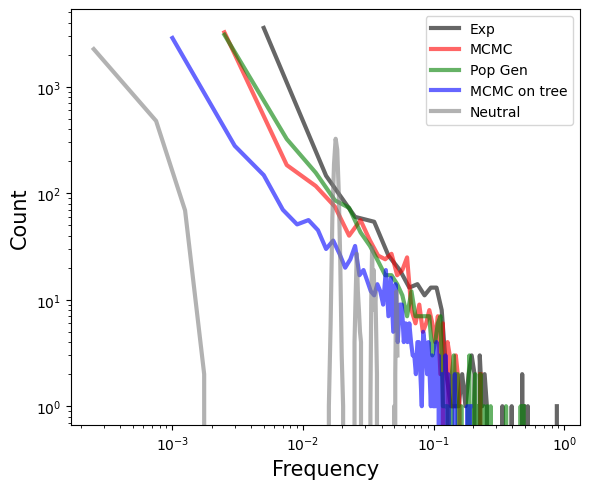

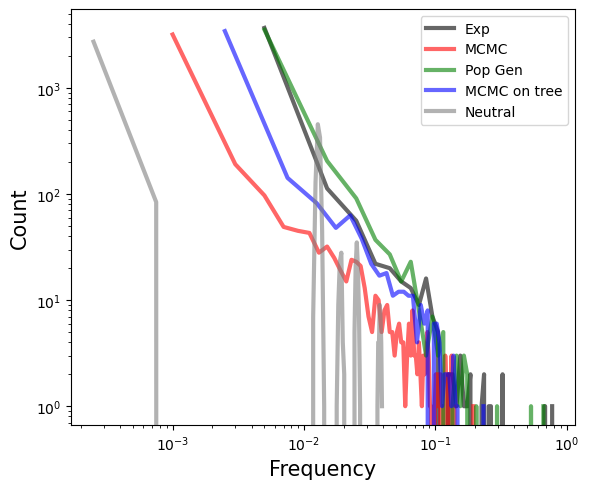

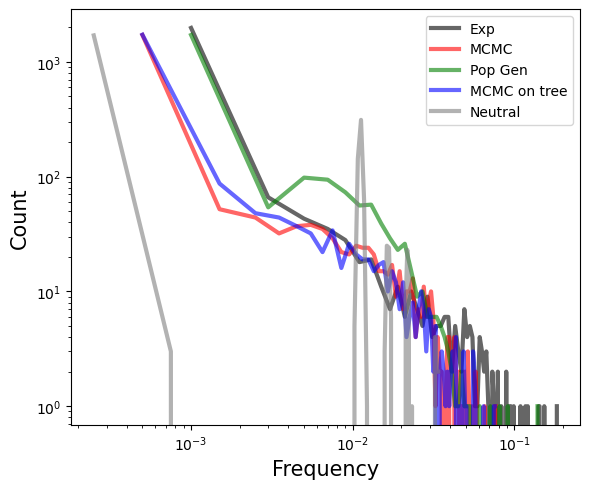

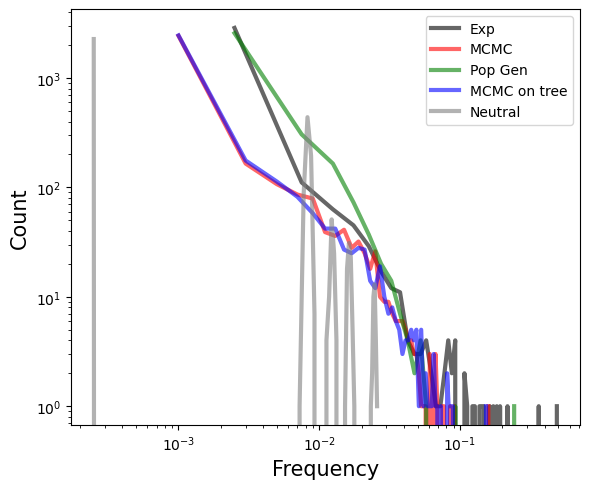

In [3]:
using PyPlot, CSV, DataFrames

function plot_sfs_from_files(
    wt_name::String,
    labels::Vector{String},
    data_folder::String,
    savepath::String
)
    default_colors = ["black", "red", "green", "blue", "grey"]
    colours = default_colors[1:length(labels)]
    figure(figsize=(6,5))
    for (i, lbl) in enumerate(labels)
        file = joinpath(data_folder, "SFS_$(wt_name)_$(lbl).csv")
        df = CSV.read(file, DataFrame)

        plot(df.midpoint, df.count,
            linewidth=3.0, alpha=0.6,
            label=lbl, color=colours[i])
    end
    xscale("log"); yscale("log")
    xlabel("Frequency", fontsize=15)
    ylabel("Count", fontsize=15)
    #title(wt_name, fontsize=18)
    legend()
    tight_layout()
    savefig(savepath, dpi=300)
    show()
end

labels = ["Exp", "MCMC", "Pop Gen", "MCMC on tree", "Neutral"]


for wt_name in ["PSE", "TEM", "AAC", "DHFR"]
    data_folder = "../../data_directed_evolution/best_fit/sfs/"
    savepath = "sfs_$(wt_name)_paper.pdf"

    plot_sfs_from_files(
        wt_name,
        labels,
        data_folder,
        savepath
    )
end


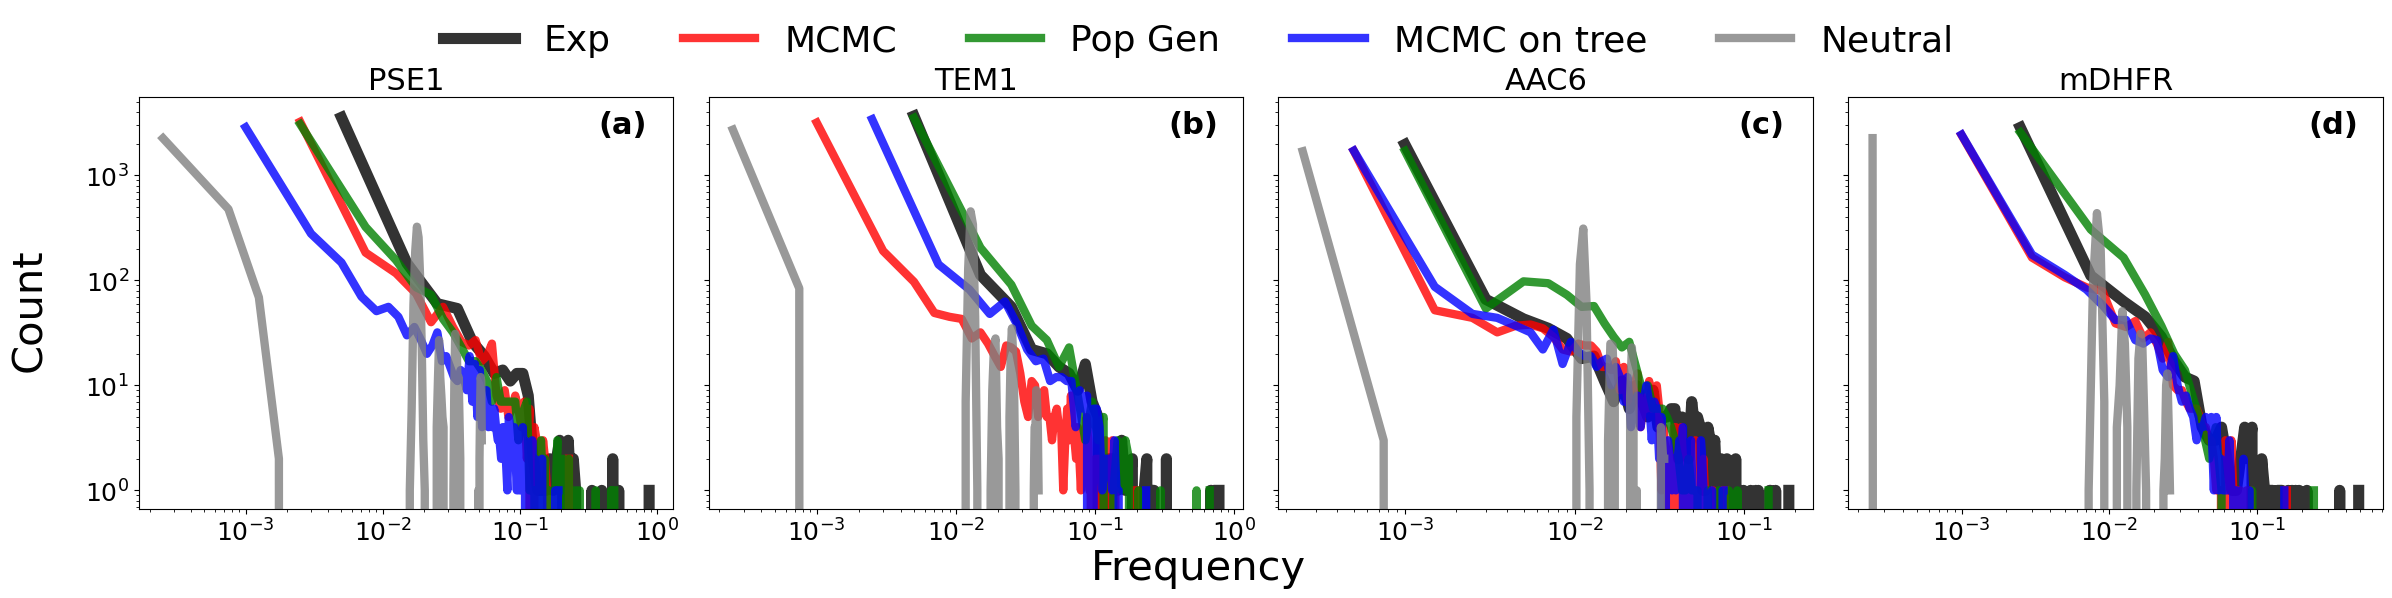

In [34]:
using PyPlot, CSV, DataFrames

# --- Configuration and Data Setup ---

# Define the models/experiments to plot
labels = ["Exp", "MCMC", "Pop Gen", "MCMC on tree", "Neutral"]
# Define the colors for the lines
colours = ["black", "red", "green", "blue", "grey"]
wt_names = ["PSE1", "TEM1", "AAC6", "mDHFR"]
wt_names2 = ["PSE", "TEM", "AAC", "DHFR"]
data_folder = "../../data_directed_evolution/best_fit/sfs/"

# --- PyPlot Implementation (1 Row, 4 Columns) ---

# Create the figure and subplots: 1 row, 4 columns
# sharey=true is kept to ensure the Y-axis limits are the same
fig, axs = subplots(1, 4, figsize=(24, 6), sharey=true) 

# Set tick label size globally
PyPlot.rc("xtick", labelsize=18)
PyPlot.rc("ytick", labelsize=18)

# Set common linewidths and transparency
line_width = 6.0 
alpha_value = 0.8

# Define subplot labels
subplot_labels = ["(a)", "(b)", "(c)", "(d)"]

# Loop through each wild-type protein
for i in 1:4
    ax = axs[i]
    wt_name = wt_names2[i]
    
    # Iterate and plot data for the current wild-type
    for (j, lbl) in enumerate(labels)
        try
            # Construct the filename
            file = joinpath(data_folder, "SFS_$(wt_name)_$(lbl).csv")
            
            # Read the CSV file into a DataFrame
            df = CSV.read(file, DataFrame)

            if lbl == "Exp"
                
                # Plot the SFS
                ax.plot(df.midpoint, df.count,
                    linewidth=line_width + 2.0, alpha=alpha_value,
                    label=lbl, color=colours[j])
            else
                ax.plot(df.midpoint, df.count,
                    linewidth=line_width, alpha=alpha_value,
                    label=lbl, color=colours[j])
            end

        catch e
            println("Could not load data for $wt_name - $lbl: $e")
        end
    end
    
    # Apply styling for the current subplot
    
    # Set both axes to logarithmic scale
    ax.set_xscale("log")
    ax.set_yscale("log")
    
    # Set the title for the subplot (just the protein name)
    ax.set_title(wt_names[i], fontsize=22)
    
    # Add the subplot label (a), (b), (c), (d)
    ax.text(0.86, 0.97, subplot_labels[i], 
            transform=ax.transAxes,
            fontsize=22, fontweight="bold", va="top")
end

# --- Common Axis Labels ---

# Common X-axis label, placed at the bottom center
fig.text(0.5, 0.05, "Frequency", 
         ha="center", fontsize=30)

# Common Y-axis label (rotated), placed on the far left, centered vertically
fig.text(0.005, 0.5, "Count", 
         va="center", rotation="vertical", fontsize=30)


# --- Legend and Saving ---

# Get handles and labels from the first subplot
handles, labels_plt = axs[1].get_legend_handles_labels()

# Place the single legend outside the plots, at the top center
# Set bbox_to_anchor=(0.5, 1.1) to ensure it's high enough
fig.legend(handles, labels_plt, loc="upper center", ncol=5,
           bbox_to_anchor=(0.5, 1.03), fontsize=26, frameon=false)

# Adjust plot layout and save
# rect=[left, bottom, right, top]
# We increased the 'top' margin slightly (to 0.93) and increased 'bottom' (to 0.08)
# and 'left' (to 0.03) to ensure all common text and legend are inside the saved area.
tight_layout(rect=[0.03, 0.08, 1, 0.93]) 
savefig("../../Fig4.pdf")

# Display the plot (optional)
show()

## Reconstruction

In [ ]:
ENV["PYTHON"] = "" 
using Pkg
Pkg.build("PyCall")  # Rebuild PyCall to use the internal Python
using Revise, PyPlot, DelimitedFiles, PhyloTools, TreeTools, DCAUtils, KitMSA

wt_name = ["PSE", "TEM", "AAC", "DHFR"]
ref_file = ["../data_directed_evolution/PSE1_pfam_DNA.fasta",
    "../data_directed_evolution/TEM1_pfam_DNA.fasta",
    "../data_directed_evolution/AAC6_pfam_DNA.fasta",
    "../data_directed_evolution/mDHFR_pfam_DNA.fasta"]
wt_seq = []
for i in 1:4
    wt = join(readdlm(ref_file[i], skipstart = 1)); # Read the reference sequence (DNA)
    L_big = round(Int,length(wt)/3)
    if wt_name[i] == "AAC" || wt_name[i] == "DHFR"
        wt_DNA_seq = [wt[((i-1)*3 +1):(i*3)] for i in 1:L_big];
    else
        # Assuming the original logic for determining sites is correct for your context
        wt_DNA_seq = [wt[((i-1)*3 +1):(i*3)] for i in 3:L_big-1];
    end
    # 2. Convert DNA codons to the integer-encoded wild-type sequence (wt_seq)
    L_sites = length(wt_DNA_seq)
    push!(wt_seq, [cod2amino[x] for x in wt_DNA_seq]);
end


# Define files, labels, and colors as in the original CDF script
trees_pse = [
    "../data_directed_evolution/TreeSingleThread_PSE_round20.nwk",
    "../data_directed_evolution/TreeSingleThread_PSE_mcmc_samples100000_T1.3_steps120_pairs10000.nwk",
    "../data_directed_evolution/TreeSingleThread_nodupl_PSE_popgen_samples1000000_T12.0_mu0.03_mubind-50.0_pairs10000.fa.nwk",
    "../data_directed_evolution/TreeSingleThread_PSE_mcmctree_T1.4_steps110_pairs10000.nwk",
]

files_pse = ["../data_directed_evolution/pse_round20_noflankgaps_nodupl.fa", 
    "../data_directed_evolution/best_fit/PSE_mcmc_samples100000_T1.3_steps120_pairs10000.fa",
    "../data_directed_evolution/best_fit/PSE_popgen_samples100000_T12.0_mu0.03_mubind-50.0_pairs10000.fa",
    "../data_directed_evolution/best_fit/PSE_mcmctree_T1.4_steps110_pairs10000.fa"
    ]

files_tem = ["../data_directed_evolution/tem_round12_noflankgaps_nodupl.fa",
    "../data_directed_evolution/best_fit/TEM_mcmc_samples100000_T1.1_steps95_pairs10000.fa",
    "../data_directed_evolution/best_fit/TEM_popgen_samples100000_T6.0_mu0.035_mubind-50.0_pairs10000.fa",
    "../data_directed_evolution/best_fit/TEM_mcmctree_T1.1_steps100_pairs10000.fa"]


files_aac = ["../data_directed_evolution/aac_round8_noflankgaps_nodupl.fa",
    "../data_directed_evolution/best_fit/AAC_mcmc_samples100000_T2.1_steps30_pairs10000.fa", 
    "../data_directed_evolution/best_fit/AAC_popgen_samples100000_T10.0_mu0.035_mubind0.0_pairs10000.fa",
    "../data_directed_evolution/best_fit/AAC_mcmctree_T1.8_steps30_pairs10000.fa"]

files_dhfr = ["../data_directed_evolution/dhfr_round15_noflankgaps_nodupl.fasta",
    "../data_directed_evolution/best_fit/DHFR_mcmc_samples100000_T2.2_steps60_pairs10000.fa",
    "../data_directed_evolution/best_fit/DHFR_popgen_samples100000_T8.0_mu0.02_mubind-10.0_pairs10000.fa", 
    "../data_directed_evolution/best_fit/DHFR_mcmctree_T2.2_steps60_pairs10000.fa"]
    
    

msas_pse = [read_fasta_alignment(file, 0.9) for file in files_pse]
msas_tem = [read_fasta_alignment(file, 0.9) for file in files_tem]
msas_dhfr = [read_fasta_alignment(file, 0.9) for file in files_dhfr]
msas_aac = [read_fasta_alignment(file, 0.9) for file in files_aac]

#=inf_mus = [infer_mu(trees_pse[i], msas_pse[i]) for i in 1:4]

ml = []
for i in 1:4
    @time res, p = Felsenstein2(msas_pse[i], trees_pse[i], msas_pse[i], inf_mus[i])
    push!(ml, res)
    push!(ps, p)
end

d_ml = [PhyloTools.ham_dist(Int.(wt_seq), Int.(pse_cons[i])) for i in 1:4]

@time inf_mus = [infer_mu(trees_pse[1], msas_pse[1])]

@time res, p = Felsenstein2(msas_pse[1], trees_pse[1], msas_pse[1], inf_mus[1])

PhyloTools.ham_dist(Int.(wt_seq), Int.(res))=#



q = 21; 
pse_cons = [PhyloTools.consensus(msa, q) for msa in msas_pse]
d_cons_pse = [PhyloTools.ham_dist(Int.(wt_seq[1]), Int.(pse_cons[i])) for i in 1:4]

tem_cons = [PhyloTools.consensus(msa, q) for msa in msas_tem]
d_cons_tem = [PhyloTools.ham_dist(Int.(wt_seq[2]), Int.(tem_cons[i])) for i in 1:4]
        
aac_cons = [PhyloTools.consensus(msa, q) for msa in msas_aac]
d_cons_aac = [PhyloTools.ham_dist(Int.(wt_seq[3]), Int.(aac_cons[i])) for i in 1:4]

dhfr_cons = [PhyloTools.consensus(msa, q) for msa in msas_dhfr]
d_cons_dhfr = [PhyloTools.ham_dist(Int.(wt_seq[4]), Int.(dhfr_cons[i])) for i in 1:4]




diff_sites_pse = [findall(Int.(wt_seq[1]) .!= Int.(pse_cons[i])) for i in 1:4]
diff_sites_tem = [findall(Int.(wt_seq[2]) .!= Int.(tem_cons[i])) for i in 1:4]
diff_sites_aac = [findall(Int.(wt_seq[3]) .!= Int.(aac_cons[i])) for i in 1:4]
diff_sites_dhfr = [findall(Int.(wt_seq[4]) .!= Int.(dhfr_cons[i])) for i in 1:4]


file_model = ["../model_natural_PSE.dat", 
    "../model_natural_PSE.dat",
    "../data_directed_evolution/Parameters_conv_AAC6.dat",
    "../data_directed_evolution/Parameters_conv_DHFR.dat"]
h = []; J = []; 
for i in 1:4
    # Read model parameters
    println("Reading model parameters")
    if wt_name[i] == "AAC" || wt_name[i] == "DHFR"
        	h_tmp, J_tmp = read_par_BM_0gapsave(file_model[i])
    else
    	h_tmp, J_tmp = read_par_BM_lettersave(file_model[i])
    end
    push!(h, set_max_field_to_0save(h_tmp));
    J_tmp2 = symmetrize_Jsave(J_tmp); 
    push!(J, permutedims(J_tmp2, [1,3,2,4]))
end

cde_wt = [PhyloTools.cont_dep_entr(wt_seq[i], h, J) for i in 1:4]

err_cdes_pse = [cde_wt[1][diff_sites_pse[i]] for i in 1:4]
err_cdes_tem = [cde_wt[2][diff_sites_tem[i]] for i in 1:4]
err_cdes_aac = [cde_wt[3][diff_sites_aac[i]] for i in 1:4]
err_cdes_dhfr = [cde_wt[4][diff_sites_dhfr[i]] for i in 1:4]

labels = ["Exp", "MCMC", "PopGen", "MCMC on tree"]
cols = ["black", "red", "green", "blue"]

close("all");
plt.hist(cde_wt[1], histtype = "step", density = true)
for i in 1:4
    for x in err_cdes_pse[i]
        plt.plot([x for _ in 1:2], [0., 0.3], color = cols[i])
    end
end
savefig("../pse_cde.png")

close("all");
plt.hist(cde_wt[2], histtype = "step", density = true)
for i in 1:4
    for x in err_cdes_tem[i]
        plt.plot([x for _ in 1:2], [0., 0.3], color = cols[i])
    end
end
savefig("../tem_cde.png")

close("all");
plt.hist(cde_wt[3], histtype = "step", density = true)
for i in 1:4
    for x in err_cdes_aac[i]
        plt.plot([x for _ in 1:2], [0., 0.3], color = cols[i])
    end
end
savefig("../aac_cde.png")

close("all");
plt.hist(cde_wt[4], histtype = "step", density = true)
for i in 1:4
    for x in err_cdes_dhfr[i]
        plt.plot([x for _ in 1:2], [0., 0.3], color = cols[i])
    end
end
savefig("../dhfr_cde.png")


cons_wt_p = [[argmax(PhyloTools.single_site_prob_cond(idx, wt_seq[i], h[i], J[i], length(wt_seq[i]))) 
        for idx in 1:length(wt_seq[i])] for i in 1:4]

perc_pse = [ham_dist(cons_wt_p[1][diff_sites_pse[i]], Int.(wt_seq[1])[diff_sites_pse[i]])/length(diff_sites_pse[i]) 
    for i in 1:4]
perc_tem = [ham_dist(cons_wt_p[1][diff_sites_tem[i]], Int.(wt_seq[1])[diff_sites_tem[i]])/length(diff_sites_tem[i]) 
    for i in 1:4]
perc_aac = [ham_dist(cons_wt_p[1][diff_sites_aac[i]], Int.(wt_seq[1])[diff_sites_aac[i]])/length(diff_sites_aac[i]) 
    for i in 1:4]
perc_dhfr = [ham_dist(cons_wt_p[1][diff_sites_dhfr[i]], Int.(wt_seq[1])[diff_sites_dhfr[i]])/length(diff_sites_dhfr[i]) 
    for i in 1:4]

[perc_pse perc_tem perc_aac perc_dhfr]

## Mutation dynamics experiments

In [28]:

ENV["PYTHON"] = "" 
using Pkg
Pkg.build("PyCall")  # Rebuild PyCall to use the internal Python
using PyPlot, DelimitedFiles
ENV["PYTHON"] = "" 
using Pkg
Pkg.build("PyCall")  # Rebuild PyCall to use the internal Python
using PyPlot, DelimitedFilesusing Genie, DelimitedFiles, DCAUtils, JLD2, PyPlot, Statistics, LinearAlgebra
import KitMSA: fasta2matrix, matrix2fasta
using PyPlot

#msas = [read_fasta_alignment(
 #       "../data_directed_evolution/tem_round$(i)_noflankgaps_nodupl.fa", 0.9) for i in [1,6,12]]


steps = [1,2,3,4,5,15]
msas = [read_fasta_alignment(
        "../../data_directed_evolution/dhfr_round$(i)_noflankgaps_nodupl.fasta", 0.9) for i in steps]





function plot_evolving_frequencies(f1_matrix::AbstractMatrix, title_str::String; threshold=0.1)
    n_steps, n_freqs = size(f1_matrix)

    figure(figsize=(8,6))

    for j in 1:n_freqs
        traj = f1_matrix[:, j]   # frequency trajectory for freq j
        if maximum(traj) ≥ threshold
            plot(1:n_steps, traj, alpha=0.6)
        end
    end

    xlabel("Step", fontsize = 18)
    ylabel("Frequency",fontsize = 18)
    title(title_str, fontsize = 18)
    #grid(true)
    tight_layout()

    # Save figure
    filename = lowercase(replace(title_str, " " => "_"))
    savefig("$(filename)_trajectories.png", dpi=300)

    println("✅ Figure saved as $(filename)_trajectories.png in $(pwd())")

    show()
end



f1_exp = [];
for x in msas
    a,b = compute_weighted_frequencies(Int8.(x), 22, 0.)
    push!(f1_exp, a[:])
end

f1_exp = reduce(vcat, (permutedims(v) for v in f1_exp))  # matrix (steps × freqs)

plot_evolving_frequencies(f1_exp, "Exp")


θ = 0.0 threshold = 0.0
M = 10944 N = 159 Meff = 10944
θ = 0.0 threshold = 0.0
M = 9029 N = 159 Meff = 9029
θ = 0.0 threshold = 0.0
M = 6168 N = 159 Meff = 6168
θ = 0.0 threshold = 0.0
M = 11213 N = 159 Meff = 11213
θ = 0.0 threshold = 0.0
M = 6208 N = 159 Meff = 6208
θ = 0.0 threshold = 0.0
M = 88013 N = 160 Meff = 88013


LoadError: DimensionMismatch: number of columns of each array must match (got (3339, 3360))

In [33]:
using KitMSA, StatsBase, DCAUtils, PyPlot

function compute_emerging_trajectories(steps::Vector{Int}, paths::Vector{String}, wt_name::String; treshold = 0.01)
    @assert length(steps) == length(paths) "steps and paths must have the same length"

    ref_file = paths[1]
    wt = join(readdlm(ref_file, skipstart = 1))
    L_big = round(Int, length(wt) / 3)
    wt_DNA_seq = if wt_name == "AAC" || wt_name == "DHFR"
        [wt[((i-1)*3 +1):(i*3)] for i in 1:L_big]
    else
        [wt[((i-1)*3 +1):(i*3)] for i in 3:L_big-1]
    end
    L_sites = length(wt_DNA_seq)
    wt_seq = [KitMSA.cod2amino[x] for x in wt_DNA_seq]
    start_msa = hcat([wt_seq for _ in 1:10]...)
    print(size(start_msa))
    # 1. Load MSAs
    msas = []
    push!(msas, start_msa)

    for path in paths[2:end]
        push!(msas,read_fasta_alignment(path, 0.9))
    end
    # 2. Compute frequency vectors for each MSA
    f1_list = []
    for msa in msas
        f1_vec, _ = compute_weighted_frequencies(Int8.(msa), 22, 0.)
        push!(f1_list, f1_vec[:])
    end

    # 3. Stack into a matrix (n_steps × n_freqs)
    f1_matrix = reduce(vcat, (permutedims(v) for v in f1_list))

    # 4. Select emerging trajectories
    keep = [
        let traj = f1_matrix[:, j]
            traj[1] < 0.1 && maximum(traj) >= 0.1
        end
        for j in 1:size(f1_matrix, 2)
    ]

    selected = f1_matrix[:, keep]

    return selected
end

using PyPlot

function plot_evolving_frequencies(steps, f1_matrix::AbstractMatrix, wt_name::String)
    n_steps, n_freqs = size(f1_matrix)

    figure(figsize=(8,6))

    for j in 1:n_freqs
        traj = f1_matrix[:, j]
        # each traj already satisfies your emerging condition, so no extra filtering needed
        plot(steps, traj, alpha=0.6)
    end

    xlabel("Round", fontsize=18)
    ylabel("Mutant frequency", fontsize=18)
    title(wt_name, fontsize=18)
    tight_layout()

    
    outfile = "../$(wt_name)_trajectories.png"
    savefig(outfile, dpi=300)

    println("✅ Saved figure: $outfile")

    show()
end

# Base folder where all your MSA files are stored
data_folder = "../data_directed_evolution"

# --- TEM ---
wt_name = "TEM"
steps = [0,1,6,12]
files = [
    "TEM1_pfam_DNA.fasta",
    "tem_round1_noflankgaps_nodupl.fa",
    "tem_round6_noflankgaps_nodupl.fa",
    "tem_round12_noflankgaps_nodupl.fa"
]

paths = [joinpath(data_folder, f) for f in files]

traj = compute_emerging_trajectories(steps, paths, wt_name)
plot_evolving_frequencies(steps, traj, wt_name * " - Exp")

# --- PSE ---
wt_name = "PSE"
steps = [0,10,20]
files = [
    "PSE1_pfam_DNA.fasta",
    "pse_round10_noflankgaps_nodupl.fa",
    "pse_round20_noflankgaps_nodupl.fa"
]

paths = [joinpath(data_folder, f) for f in files]

traj = compute_emerging_trajectories(steps, paths, wt_name)
plot_evolving_frequencies(steps, traj, wt_name * " - Exp")

# --- DHFR ---
wt_name = "DHFR"
steps = [0,1,2,3,4,5,15]
files = [
    "mDHFR_pfam_DNA.fasta",
    "dhfr_round1_noflankgaps_nodupl.fasta",
    "dhfr_round2_noflankgaps_nodupl.fasta",
    "dhfr_round3_noflankgaps_nodupl.fasta",
    "dhfr_round4_noflankgaps_nodupl.fasta",
    "dhfr_round5_noflankgaps_nodupl.fasta",
    "dhfr_round15_noflankgaps_nodupl.fasta"
]

paths = [joinpath(data_folder, f) for f in files]

traj = compute_emerging_trajectories(steps, paths, wt_name)
plot_evolving_frequencies(steps, traj, wt_name * " - Exp")


(199, 10)θ = 0.0 threshold = 0.0
M = 10 N = 199 Meff = 10
θ = 0.0 threshold = 0.0
M = 108339 N = 199 Meff = 108339
θ = 0.0 threshold = 0.0
M = 97697 N = 199 Meff = 97697
θ = 0.0 threshold = 0.0
M = 30949 N = 199 Meff = 30949
✅ Saved figure: ../../TEM - Exp_trajectories.png
(199, 10)θ = 0.0 threshold = 0.0
M = 10 N = 199 Meff = 10
θ = 0.0 threshold = 0.0
M = 43082 N = 199 Meff = 43082
θ = 0.0 threshold = 0.0
M = 423798 N = 199 Meff = 423798
✅ Saved figure: ../../PSE - Exp_trajectories.png
(160, 10)θ = 0.0 threshold = 0.0
M = 10 N = 160 Meff = 10
θ = 0.0 threshold = 0.0
M = 10944 N = 159 Meff = 10944
θ = 0.0 threshold = 0.0
M = 9029 N = 159 Meff = 9029
θ = 0.0 threshold = 0.0
M = 6168 N = 159 Meff = 6168
θ = 0.0 threshold = 0.0
M = 11213 N = 159 Meff = 11213
θ = 0.0 threshold = 0.0
M = 6208 N = 159 Meff = 6208


LoadError: DimensionMismatch: number of columns of each array must match (got (3360, 3339))

In [ ]:
function compute_emerging_trajectories_sil(steps::Vector{Int}, msas, wt_name::String)
       # 2. Compute frequency vectors for each MSA
    f1_list = []
    for msa in msas
        f1_vec, _ = compute_weighted_frequencies(Int8.(msa), 22, 0.)
        push!(f1_list, f1_vec[:])
    end

    # 3. Stack into a matrix (n_steps × n_freqs)
    f1_matrix = reduce(vcat, (permutedims(v) for v in f1_list))

    # 4. Select emerging trajectories
    keep = [
        let traj = f1_matrix[:, j]
            traj[1] < 0.1 && maximum(traj) >= 0.1
        end
        for j in 1:size(f1_matrix, 2)
    ]

    selected = f1_matrix[:, keep]

    return selected
end


In [ ]:
ENV["PYTHON"] = "" 
using Pkg
Pkg.build("PyCall")  # Rebuild PyCall to use the internal Python
using Genie, DelimitedFiles, DCAUtils, JLD2, PyPlot, Statistics, LinearAlgebra
import KitMSA: fasta2matrix, matrix2fasta

ENV["PYTHON"] = "" 
using Pkg
Pkg.build("PyCall")  # Rebuild PyCall to use the internal Python
using Genie, DelimitedFiles, DCAUtils, JLD2, PyPlot, Statistics, LinearAlgebra
import KitMSA: fasta2matrix, matrix2fasta, cod2amino
using PyPlot



function compute_emerging_trajectories_sil(steps::Vector{Int}, msas, wt_name::String)
       # 2. Compute frequency vectors for each MSA
    f1_list = []
    for msa in msas
        f1_vec, _ = compute_weighted_frequencies(Int8.(msa), 22, 0.)
        push!(f1_list, f1_vec[:])
    end

    # 3. Stack into a matrix (n_steps × n_freqs)
    f1_matrix = reduce(vcat, (permutedims(v) for v in f1_list))

    # 4. Select emerging trajectories
    keep = [
        let traj = f1_matrix[:, j]
            traj[1] < 0.1 && maximum(traj) >= 0.1
        end
        for j in 1:size(f1_matrix, 2)
    ]

    selected = f1_matrix[:, keep]

    return selected
end


wt_name = "TEM"
Nseqs = 10^5
file_wt = "../data_directed_evolution/TEM1_pfam_DNA.fasta"
file_model = "../model_natural_PSE.dat"

# Read model parameters
println("Reading model parameters")
if wt_name == "AAC" || wt_name == "DHFR"
    	h_tmp, J_tmp = read_par_BM_0gapsave(file_model)
else
	h_tmp, J_tmp = read_par_BM_lettersave(file_model)
end
h = set_max_field_to_0save(h_tmp);
J_tmp2 = symmetrize_Jsave(J_tmp); 
J = permutedims(J_tmp2, [1,3,2,4]);



# Reading sequences in the seed
println("Reading sequences in the seed")
wt = join(readdlm(file_wt, skipstart = 1));
L_big = round(Int,length(wt)/3)
if wt_name == "AAC" || wt_name == "DHFR"
	wt_DNA_seq = [wt[((i-1)*3 +1):(i*3)] for i in 1:L_big];
else
	wt_DNA_seq = [wt[((i-1)*3 +1):(i*3)] for i in 3:L_big-1];
end
wt_seq = [cod2amino[x] for x in wt_DNA_seq];


# Performing evolution and writing files
println("Performing evolution and writing files")


Nsteps = 120
temp = 1.3
rounds = 20
start_msa = hcat([wt_DNA_seq for i in 1:Nseqs]...); 
mcmc = run_evolution(start_msa, 
    h, 
    J,
    p = 0., 
    temp = temp, 
    N_steps = Nsteps, 
    each_step = 6,
    verbose = false);

popgen = Genie.run_dir_evol_nucleo(wt_DNA_seq, Nseqs, h, J;
                   rounds = rounds,
                   each_step = 1,
                   seq_reads = Nseqs,
                   temp = 12.0,
                   mu = 0.03,
                   mu_bind = -50.0);


traj_mcmc = compute_emerging_trajectories_sil([i for i in 1:rounds], mcmc.step_msa, wt_name)
traj_popgen = compute_emerging_trajectories_sil([i for i in 1:rounds], popgen.step_msa, wt_name)


plot_evolving_frequencies([i for i in 1:rounds], traj_mcmc, wt_name * " - MCMC")
plot_evolving_frequencies([i for i in 1:rounds], traj_popgen, wt_name * " - PopGen (all)")

exp_rounds = [0,10,20]
traj_sub = zeros(rounds+1,size(traj_popgen,2))
traj_sub[2:end,:] .= traj_popgen
plot_evolving_frequencies(exp_rounds, traj_sub[exp_rounds .+ 1,:], wt_name * " - PopGen (sub)")


wt_name = "TEM"
Nseqs = 10^5
file_wt = "../../data_directed_evolution/TEM1_pfam_DNA.fasta"
file_model = "../model_natural_PSE.dat"

# Read model parameters
println("Reading model parameters")
if wt_name == "AAC" || wt_name == "DHFR"
    	h_tmp, J_tmp = read_par_BM_0gapsave(file_model)
else
	h_tmp, J_tmp = read_par_BM_lettersave(file_model)
end
h = set_max_field_to_0save(h_tmp);
J_tmp2 = symmetrize_Jsave(J_tmp); 
J = permutedims(J_tmp2, [1,3,2,4]);

# Reading sequences in the seed
println("Reading sequences in the seed")
wt = join(readdlm(file_wt, skipstart = 1));
L_big = round(Int,length(wt)/3)
if wt_name == "AAC" || wt_name == "DHFR"
	wt_DNA_seq = [wt[((i-1)*3 +1):(i*3)] for i in 1:L_big];
else
	wt_DNA_seq = [wt[((i-1)*3 +1):(i*3)] for i in 3:L_big-1];
end
wt_seq = [cod2amino[x] for x in wt_DNA_seq];


# Performing evolution and writing files
println("Performing evolution and writing files")


Nsteps = 95
temp = 1.1
rounds = 12
start_msa = hcat([wt_DNA_seq for i in 1:Nseqs]...); 
mcmc = run_evolution(start_msa, 
    h, 
    J,
    p = 0., 
    temp = temp, 
    N_steps = Nsteps, 
    each_step = round(Int, Nsteps/rounds),
    verbose = false);

popgen = Genie.run_dir_evol_nucleo(wt_DNA_seq, Nseqs, h, J;
                   rounds = rounds,
                   each_step = 1,
                   seq_reads = Nseqs,
                   temp = 6.0,
                   mu = 0.035,
                   mu_bind = -50.0);


traj_mcmc = compute_emerging_trajectories_sil([i for i in 1:rounds], mcmc.step_msa, wt_name)
traj_popgen = compute_emerging_trajectories_sil([i for i in 1:rounds], popgen.step_msa, wt_name)
plot_evolving_frequencies([i for i in 1:rounds], traj_mcmc, wt_name * " - MCMC")
plot_evolving_frequencies([i for i in 1:rounds], traj_popgen, wt_name * " - PopGen (all)")

exp_rounds = [0,1,6,12]
traj_sub = zeros(rounds+1,size(traj_popgen,2))
traj_sub[2:end,:] .= traj_popgen
plot_evolving_frequencies(exp_rounds, traj_sub[exp_rounds .+ 1,:], wt_name * " - PopGen (sub)")











In [ ]:
transition_codons = create_nested_codon_dict_no_same()

function syn_nonsyn(codon1::String, codon2::String)
    count = 0
    if cod2amino[codon1] !== cod2amino[codon2]
        count+=1
    end
    return count
end

function nonsyn_dist(codonseq1::Vector{String}, codonseq2::Vector{String})
    return sum([syn_nonsyn(codonseq1[i], codonseq2[i]) for i in 1:length(codonseq1)])
end

function nonsyn_dist(codon_seq::Vector{String}, codon_msa::Matrix{String})
    return [nonsyn_dist(codon_seq, codon_msa[:,i]) for i in 1:size(codon_msa,2)]
end

function nucleo_dist(cod1::String, cod2::String)
    return sum(collect(cod1) .!= collect(cod2))
end

function nucleo_dist(codseq1::Vector{String}, codseq2::Vector{String})
    return [nucleo_dist(codseq1[i], codseq2[i]) for i in 1:length(codseq1)]
end

d_non_popgen = nonsyn_dist(wt_DNA_seq, popgen.step_msa_dna[end]);
d_non_mcmc = nonsyn_dist(wt_DNA_seq, mcmc.step_msa_dna[end]);


function codon_neighbors_nosame()
    codons = ["A", "C", "G", "T"]
    codon_dict = Dict{String, Vector{String}}()

    for a in codons, b in codons, c in codons
        old_codon = string(a, b, c)
        if old_codon != "TAA" && old_codon != "TAG" && old_codon != "TGA" 
            codon_list = String[]
        
            for i in 1:3
                for nucl in codons
                    if nucl != old_codon[i]
                        new_codon = string(old_codon[1:i-1], nucl, old_codon[i+1:end])
                        if new_codon != "TAA" && new_codon != "TAG" && new_codon != "TGA" && new_codon != old_codon
                            push!(codon_list, new_codon)
                        end
                    end
                end
            end
            codon_dict[old_codon] = unique(codon_list)
        end
    end

    return codon_dict
end

function syn_positions(dnaseq)
    transition_codons = codon_neighbors_nosame()
    new_codons = [transition_codons[cod] for cod in dnaseq]
    count = 0; 
    for i in 1:length(dnaseq)
        if dnaseq[i] in [cod2amino[x] for x in new_codons[i]]
            count+=1
        end
    end
    return count
end

    

    

In [2]:
using JLD2

In [3]:
function plot_evolving_frequencies(f1_matrix::AbstractMatrix, title_str::String; threshold=0.1)
    n_steps, n_freqs = size(f1_matrix)

    figure(figsize=(8,6))

    for j in 1:n_freqs
        traj = f1_matrix[:, j]   # frequency trajectory for freq j
        if maximum(traj) ≥ threshold
            plot(1:n_steps, traj, alpha=0.6)
        end
    end

    xlabel("Step", fontsize = 18)
    ylabel("Frequency",fontsize = 18)
    title(title_str, fontsize = 18)
    #grid(true)
    tight_layout()

    # Save figure
    filename = lowercase(replace(title_str, " " => "_"))
    savefig("$(filename)_trajectories.png", dpi=300)

    println("✅ Figure saved as $(filename)_trajectories.png in $(pwd())")

    show()
end

plot_evolving_frequencies (generic function with 1 method)

In [4]:
@load "../../traj_graph_abstract_popgen.jld2"

2-element Vector{Symbol}:
 :traj_mcmc
 :traj_popgen

✅ Figure saved as traj_graph_abstract_arrows.png in /home/disat/ldibari/Genie.jl/popgen


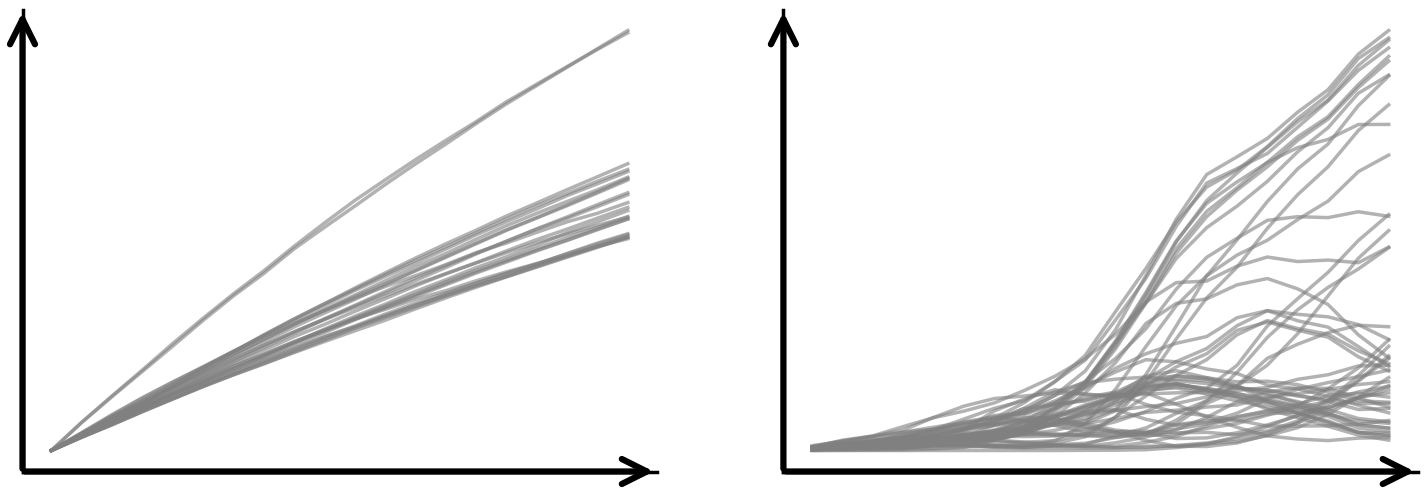

In [26]:
using PyPlot

threshold = 0.11
n_steps, n_freqs_A = size(traj_mcmc)
_, n_freqs_B = size(traj_popgen)

figure(figsize=(18,6))

# Common spine/axis formatting function with arrows
function format_axes_with_arrows(ax; arrow_size=20)
    # Remove top and right spines
    ax[:spines]["top"].set_visible(false)
    ax[:spines]["right"].set_visible(false)
    # Thicken bottom and left spines
    ax[:spines]["bottom"].set_linewidth(2.5)
    ax[:spines]["left"].set_linewidth(2.5)
    # Remove ticks
    ax[:tick_params](bottom=false, left=false, labelbottom=false, labelleft=false)
    
    # Add arrows
    xlim = ax[:get_xlim]()
    ylim = ax[:get_ylim]()
    
    # x-axis arrow
    ax[:annotate]("", xy=(xlim[2], ylim[1]), xytext=(xlim[1], ylim[1]),
                  arrowprops=Dict(:arrowstyle=>"->", :lw=>4.5, :color=>"black",
                  :mutation_scale=>45))
    # y-axis arrow
    ax[:annotate]("", xy=(xlim[1], ylim[2]), xytext=(xlim[1], ylim[1]),
                  arrowprops=Dict(:arrowstyle=>"->", :lw=>4.5, :color=>"black",
                  :mutation_scale=>45  ))
end

# Panel A
ax1 = subplot(1,2,1)
for j in 1:n_freqs_A
    traj = traj_mcmc[:, j]
    if maximum(traj) ≥ threshold
        plot(1:n_steps, traj, alpha=0.6, linewidth=2.5, color="grey")
    end
end

format_axes_with_arrows(ax1)

# Panel B
ax2 = subplot(1,2,2)
for j in 1:n_freqs_B
    traj = traj_popgen[:, j]
    if maximum(traj) ≥ threshold
        plot(1:n_steps, traj, alpha=0.6, linewidth=2.5, color="grey")
    end
end

format_axes_with_arrows(ax2)

# Tight layout, subplots close
#tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

# Save figure
savefig("../../traj_graph_abstract_arrows.png", dpi=300)
println("✅ Figure saved as traj_graph_abstract_arrows.png in $(pwd())")

show()


## predicting mutations

In [1]:


ENV["PYTHON"] = "" 
using Pkg
Pkg.build("PyCall")  # Rebuild PyCall to use the internal Python
using PyPlot, DelimitedFiles
ENV["PYTHON"] = "" 
using Pkg
Pkg.build("PyCall")  # Rebuild PyCall to use the internal Python
using PyPlot, DelimitedFiles
using Genie, DelimitedFiles, DCAUtils, JLD2, PyPlot, Statistics, LinearAlgebra
import KitMSA: fasta2matrix, matrix2fasta
using PyPlot
using StatsBase



wt_name = "TEM"
Nseqs = 10^5
file_wt = "../data_directed_evolution/TEM1_pfam_DNA.fasta"
file_model = "../model_natural_PSE.dat"

# Read model parameters
println("Reading model parameters")
if wt_name == "AAC" || wt_name == "DHFR"
    	h_tmp, J_tmp = read_par_BM_0gapsave(file_model)
else
	h_tmp, J_tmp = read_par_BM_lettersave(file_model)
end
h = set_max_field_to_0save(h_tmp);
J_tmp2 = symmetrize_Jsave(J_tmp); 
J = permutedims(J_tmp2, [1,3,2,4]);

# Reading sequences in the seed
println("Reading sequences in the seed")
wt = join(readdlm(file_wt, skipstart = 1));
L_big = round(Int,length(wt)/3)
if wt_name == "AAC" || wt_name == "DHFR"
	wt_DNA_seq = [wt[((i-1)*3 +1):(i*3)] for i in 1:L_big];
else
	wt_DNA_seq = [wt[((i-1)*3 +1):(i*3)] for i in 3:L_big-1];
end
wt_seq = [cod2amino[x] for x in wt_DNA_seq];



function codon_to_amino_min_dist(cod1::String, amino::Int)
    return minimum([Genie.cod_dist(cod1, KitMSA.amino2cod[amino][i]) for i in 1:length(KitMSA.amino2cod[amino])])
end

function codon_to_amino_mean_dist(cod1::String, amino::Int)
    return mean([Genie.cod_dist(cod1, KitMSA.amino2cod[amino][i]) for i in 1:length(KitMSA.amino2cod[amino])])
end


function codon_dist_from_msa(dna_seq::Vector; q::Int = 21)
    L = length(dna_seq)
    res = zeros(q,L)

    for a in 1:q
        for i in 1:L
            res[a,i] = codon_to_amino_mean_dist(dna_seq[i], a)
        end
    end

    return res
end


d_nucl = codon_dist_from_msa(wt_DNA_seq)

msa_half = read_fasta_alignment("../data_directed_evolution/tem_round6_noflankgaps_nodupl.fa", 0.9);
msa = read_fasta_alignment("../data_directed_evolution/tem_round12_noflankgaps_nodupl.fa", 0.9);
popgen_msa = read_fasta_alignment("../data_directed_evolution/best_fit/TEM_popgen_samples100000_T6.0_mu0.035_mubind-50.0_pairs10000.fa", 0.9)
mcmc_msa = read_fasta_alignment("../data_directed_evolution/best_fit/TEM_mcmc_samples100000_T1.1_steps95_pairs10000.fa", 0.9)
mcmctree_msa = read_fasta_alignment("../data_directed_evolution/best_fit/TEM_mcmctree_T1.1_steps100_pairs10000.fa", 0.9)


f1,f2 = compute_weighted_frequencies(msa_half, 22, 0.); f1_exp_half = reshape(f1, 21, 199)
f1,f2 = compute_weighted_frequencies(msa, 22, 0.); f1_exp = reshape(f1, 21, 199)
f1,f2 = compute_weighted_frequencies(popgen_msa, 22, 0.); f1_popgen = reshape(f1, 21, 199)
f1,f2 = compute_weighted_frequencies(mcmc_msa, 22, 0.); f1_mcmcm = reshape(f1, 21, 199)
f1,f2 = compute_weighted_frequencies(mcmctree_msa, 22, 0.); f1_mcmctree = reshape(f1, 21, 199)




dms_DCA = zeros(21, 199);for a in 1:21; for i in 1:199 ss = copy(wt_seq); ss[i] = a; dms_DCA[a,i] = delta_energy(h, J, ss, wt_seq) end end

mask = ones(21, 199); for (i,a) in enumerate(wt_seq)  mask[a,i] = 0 end; mask = Bool.(mask)

cor(dms_DCA[:], f1_exp[:])
cor(d_nucl[:], f1f1_exp[:])
cor(dms_DCA[mask][:], f1f1_exp[mask][:])
cor(d_nucl[mask][:], f1f1_exp[mask][:])

close("all"); plt.scatter(delta_E[:], f1[:]); savefig("../ciao.png")



msa_clean = read_fasta_alignment("../TEM1_var_MSA_clean.fasta", 0.9)

d = ham_dist(wt_seq, msa_clean)
df_full = readdlm("../TEM1_var_fit.txt", skipstart=1)[:]



df_sum = zeros(21, 199); df_count = zeros(21, 199);  for ind in 1:length(df_full)
    if (d[ind] == 1) && (df_full[ind] != "missing")
        i = findall(wt_seq .!== msa_clean[:,ind])[1]
        df_sum[msa_clean[i,ind],i] += df_full[ind]
        df_count[msa_clean[i,ind],i] += 1        
    end
end
df = df_sum ./ df_count

mask_nan = .!isnan.(df)

cor(dms_DCA[mask_nan][:], df[mask_nan][:])
cor(d_nucl[mask_nan][:], df[mask_nan][:])
cor(df[mask_nan][:], f1_exp[mask_nan][:])


close("all")
plt.scatter(
    df[mask_nan][:],
    f1_exp[mask_nan][:],
    c=d_nucl[mask_nan][:],   # your color vector here
)
plt.colorbar()              # add a colorbar to see the scale
plt.yscale("log")
plt.xlabel("deltaF exp")
plt.ylabel("frequency exp round 12")
savefig("../df_vs_fexp.png")


close("all")
plt.scatter(
    d_nucl[mask_nan][:],
    f1_exp[mask_nan][:] ,
    c=df[mask_nan][:],   # your color vector here
)
plt.colorbar()              # add a colorbar to see the scale
plt.yscale("log")
plt.xlabel("nucleo mean distance")
plt.ylabel("frequency exp round 12")
savefig("../distance_vs_fexp.png")



close("all")
plt.scatter(
    df[mask_nan][:],
    f1_exp_half[mask_nan][:],
    c=d_nucl[mask_nan][:],   # your color vector here
)
plt.colorbar()              # add a colorbar to see the scale
plt.yscale("log")
plt.xlabel("deltaF exp")
plt.ylabel("frequency exp round 6")
savefig("../df_vs_fexphalf.png")


close("all")
plt.scatter(
    df[mask_nan][:],
    f1_popgen[mask_nan][:],
    c=d_nucl[mask_nan][:],   # your color vector here
)
plt.colorbar()              # add a colorbar to see the scale
plt.yscale("log")
plt.xlabel("deltaF exp")
plt.ylabel("frequency Pop Gen")
savefig("../df_vs_fpopgen.png")



close("all")
plt.scatter(
    df[mask_nan][:],
    f1_mcmc[mask_nan][:],
    c=d_nucl[mask_nan][:],   # your color vector here
)
plt.colorbar()              # add a colorbar to see the scale
plt.yscale("log")
plt.xlabel("deltaF exp")
plt.ylabel("frequency MCMC")
savefig("../df_vs_fmcmc.png")



close("all")
plt.scatter(
    df[mask_nan][:],
    f1_mcmctree[mask_nan][:],
    c=d_nucl[mask_nan][:],   # your color vector here
)
plt.colorbar()              # add a colorbar to see the scale
plt.yscale("log")
plt.xlabel("deltaF exp")
plt.ylabel("frequency MCMC on tree")
savefig("../df_vs_fmcmctree.png")


close("all")
plt.scatter(
    dms_DCA[mask_nan][:],
    f1_exp[mask_nan][:],
    c=d_nucl[mask_nan][:],   # your color vector here
)
plt.colorbar()              # add a colorbar to see the scale
plt.yscale("log")
plt.xlabel("deltaE DCA")
plt.ylabel("frequency exp")
savefig("../dE_vs_fexp.png")



LoadError: UndefVarError: `wt_DNA_seq` not defined